Engineer: Adeola Odunewu
Intern: FlipRobo LLC DS1123
Project: Loan Application Status Classification

In [1]:
#Importing required library
import os
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.svm import SVC
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message=".*deprecated.*")


In [2]:
# Data URL
url = r'https://github.com/adeolalumi/Evaluation-Projects-FlipRobo-/raw/main/Loan_Application_Status.%20Project/loan_prediction.csv'


In [3]:
# Read the CSV file directly from the URL
df = pd.read_csv(url)


In [4]:
# Display the first few rows of the DataFrame
df.head()


,LP001002,Male,No,0,Graduate,No.1,5849,0.1,Unnamed: 8,360,1,Urban,Y
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


Exploratory Data Analysis

In [6]:
# Count the number of unique values in each column and create a DataFrame with the results
unique_value_counts = df.nunique().to_frame("Unique Values")
print(unique_value_counts)

            Unique Values
LP001002              613
Male                    2
No                      2
0                       4
Graduate                2
No.1                    2
5849                  504
0.1                   287
Unnamed: 8            203
360                    10
1                       2
Urban                   3
Y                       2


In [7]:
# Display information about the combined DataFrame, such as column data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LP001002    613 non-null    object 
 1   Male        600 non-null    object 
 2   No          610 non-null    object 
 3   0           598 non-null    object 
 4   Graduate    613 non-null    object 
 5   No.1        581 non-null    object 
 6   5849        613 non-null    int64  
 7   0.1         613 non-null    float64
 8   Unnamed: 8  592 non-null    float64
 9   360         599 non-null    float64
 10  1           563 non-null    float64
 11  Urban       613 non-null    object 
 12  Y           613 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [8]:

# Readdressing the DataFrame
df.rename(columns={'LP001002': 'Loan_ID', 
                   'Male': 'Gender',
                   'No': 'Married',
                   '0': 'Dependents',
                   'Graduate': 'Education',
                   'No.1': 'Self_Employed',
                   '5849': 'Applicant Income',
                   '0.1': 'CoapplicantIncome',
                   'Unnamed: 8': 'Loan_Amount',
                   '360': 'Loan_Amount_Term',
                   '1': 'Credit History',
                   'Urban': 'Property_Area',
                   'Y': 'Loan_Status'}, inplace=True)


In [13]:
# data contained in df
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant Income,CoapplicantIncome,Loan_Amount,Loan_Amount_Term,Credit History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
609,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
610,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
611,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [9]:
# Selecting columns with int64 or float64 dtype from the DataFrame and printing them
numeric_df = df.select_dtypes(include=['int64', 'float64'])


In [10]:
numeric_df.describe()

,Applicant Income,CoapplicantIncome,Loan_Amount,Loan_Amount_Term,Credit History
count,613.000000,613.000000,592.000000,599.000000,563.000000
mean,5402.732463,1623.890571,146.412162,341.969950,0.841918
std,6114.004114,2927.903583,85.587325,65.170672,0.365142
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2876.000000,0.000000,100.000000,360.000000,1.000000
50%,3812.000000,1210.000000,128.000000,360.000000,1.000000
75%,5780.000000,2302.000000,168.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [11]:
# Selecting columns with object dtype from the DataFrame and printing them
cate_df = df.select_dtypes(include=['object'])


In [14]:
cate_df.describe()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,613,600,610,598,613,581,613,613
unique,613,2,2,4,2,2,3,2
top,LP001003,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,488,398,344,479,499,233,421


The dataset is specified accordingly, and a statistics of the data is output with a single line of code.

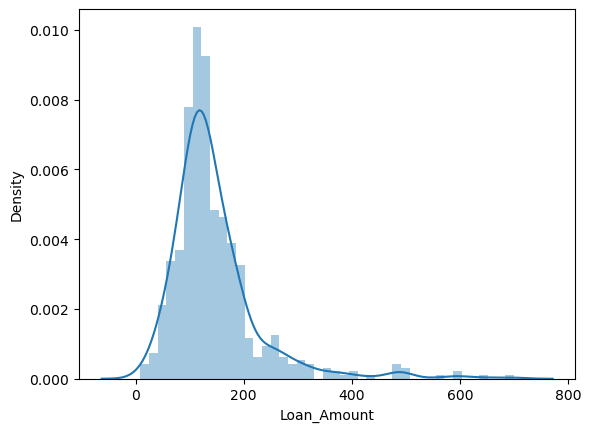

In [15]:
# Univariate Analysis:
# Create a distribution plot for the loan amounts
sns.distplot(df['Loan_Amount'])
plt.show()

Text: 1
The distribution of loan amounts is skewed to the right, indicating that a small number of large loans are pulling the average (mean) 
upward. This means that while most borrowers receive relatively smaller loans, the presence of these outliers can distort the overall picture of 
loan amounts.

To better represent the typical loan amount, I will use the median. The median is less sensitive to extreme values, providing a more accurate 
reflection of the central tendency in the data.

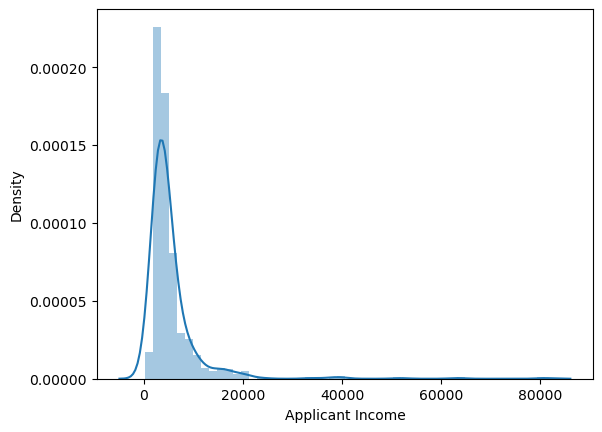

count      613.000000
mean      5402.732463
std       6114.004114
min        150.000000
25%       2876.000000
50%       3812.000000
75%       5780.000000
max      81000.000000
Name: Applicant Income, dtype: float64


In [16]:
# Create a distribution plot for the Applicant Income
sns.distplot(df['Applicant Income'])
plt.show()

# Summary statistics for the 'Applicant Income' column
summary = df['Applicant Income'].describe()
print(summary)

The standard deviation exceeds the mean by 712, indicating that the mean may not accurately represent the dataset due to significant variation in the
values. Therefore, the median (50th percentile, 3812.00) is a more appropriate measure of central tendency for skewed data, as it reflects the middle 
value and remains unaffected by extreme outliers.

Bivariate Analysis:

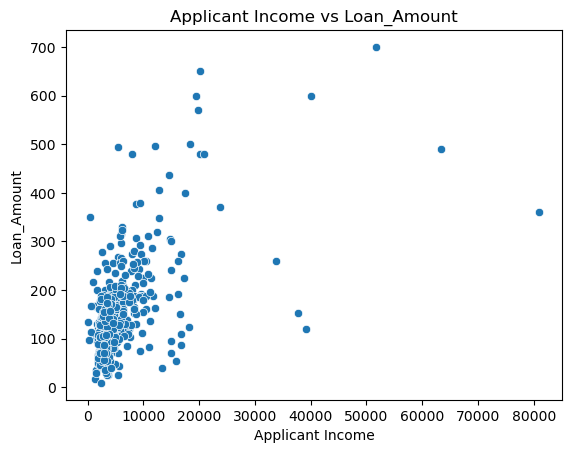

In [17]:

# List of continuous variables for which scatter plots need to be created
continuous_variables = ['Applicant Income', 'Loan_Amount']

# Create scatter plots for each pair of continuous variables
for i in range(len(continuous_variables)):
    for j in range(i+1, len(continuous_variables)):
        sns.scatterplot(x=df[continuous_variables[i]], y=df[continuous_variables[j]])
        plt.xlabel(continuous_variables[i])
        plt.ylabel(continuous_variables[j])
        plt.title(f"{continuous_variables[i]} vs {continuous_variables[j]}")
        plt.show()

Text 2:
The analysis suggests that applicants with lower incomes are more likely to apply for loans compared to those with higher incomes. As shown in the 
provided data, the median income of applicants is $3,812. This means that 50% of applicants earn less than or equal to this amount.

Furthermore, the quartiles reveal that 25% of applicants have an income of $2,876 or less, while 75% have an income of $5,780 or less. 
These figures highlight the concentration of loan applicants in lower income brackets.

The outcome comprises a series of scatter plots illustrating the relationship between Loan Amounts and Applicant Income. Each plot features 
both variables labelled on the x-axis and y-axis, respectively. This visualization aids in understanding potential patterns between low and 
high-income earners. Notably, it suggests that low-income earners might find it comparatively easier to secure 
loans compared to their higher-earning counterparts.

Multivariate Analysis:

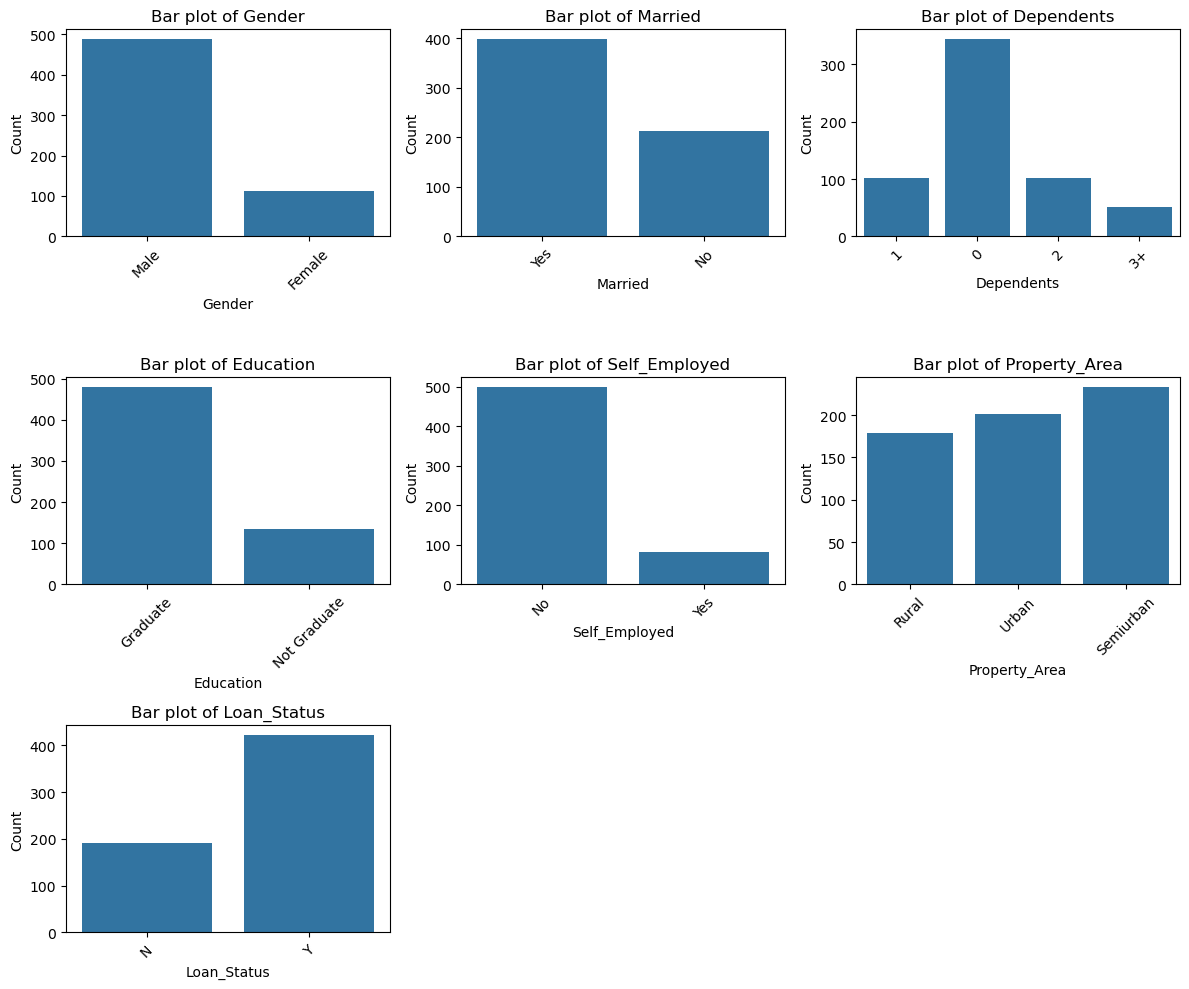

In [18]:

# Bar plots for categorical variables

categorical_variables = df.select_dtypes(include=['object'])
cata = categorical_variables.drop('Loan_ID', axis=1)

plt.figure(figsize=(12, 10))

# Enumerating over the columns of `cata` (categorical variables without 'Loan_ID')
for i, var in enumerate(cata.columns, 1):
    plt.subplot(3, 3, i)  # Adjust based on how many subplots you want in a row
    sns.countplot(data=df, x=var)
    plt.title(f'Bar plot of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

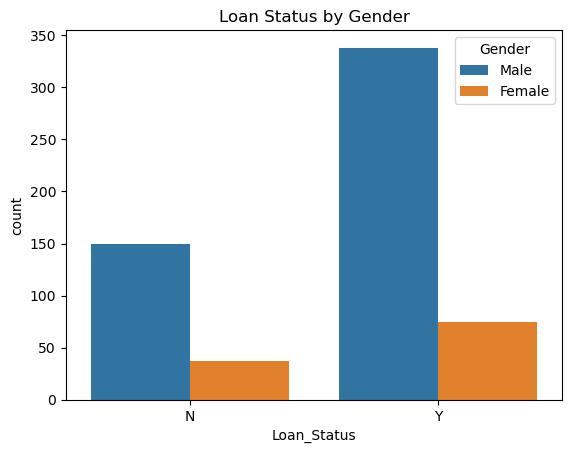

(array([0, 1]), [Text(0, 0, 'N'), Text(1, 0, 'Y')])

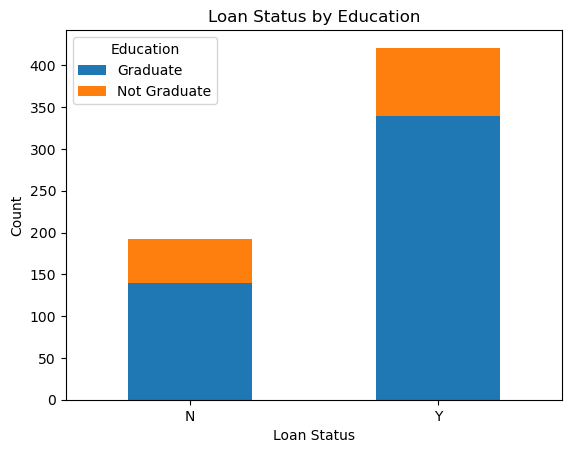

In [19]:
# Example: Loan_Status by Gender
sns.countplot(x='Loan_Status', hue='Gender', data=df)
plt.title('Loan Status by Gender')
plt.show()

# Example: Cross-tabulation of Loan_Status and Education
cross_tab = pd.crosstab(index=df['Loan_Status'], columns=df['Education'])
cross_tab.plot(kind='bar', stacked=True)
plt.title('Loan Status by Education')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks(rotation=0)

Text 3: 
The analysis indicates that graduate applicants are more likely to have their loan applications approved compared to non-graduate applicants. 
Additionally, male applicants tend to apply for loans more frequently than female applicants.

The categorical plot further illustrates the various factors that influence loan approval status, providing insights into the unique characteristics 
and circumstances of loan applicants.

In [20]:
# Handling missing values
missing_data = df.isnull().sum()
print(missing_data)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
Applicant Income      0
CoapplicantIncome     0
Loan_Amount          21
Loan_Amount_Term     14
Credit History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [21]:
# Iterate over each column and impute missing values with the median
for column in df.columns:
    if df[column].dtype != object:  # Check if the column contains numeric data
        median_value = df[column].median()  # Calculate the median value of the column
        df[column].fillna(median_value, inplace=True)  # Fill missing values with the median

In [22]:
# List of columns with categorical data
categorical_columns = df.select_dtypes(include=['object'])

# Iterate over each column and replace missing values with the mode
for column in categorical_columns:
    mode_value = df[column].mode().iloc[0]  # Calculate the mode value of the column
    df[column].fillna(mode_value, inplace=True)  # Fill missing values with the mode

Teext 4: 
The code iterates over each column in the DataFrame. For numeric columns, it fills missing values with the median of that column, while for categorical columns, it fills missing values with the mode. This approach ensures that missing values are replaced appropriately based on the data type of each column.

In [23]:
# Rechecking missing data
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
Applicant Income     0
CoapplicantIncome    0
Loan_Amount          0
Loan_Amount_Term     0
Credit History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [24]:
# Select only the numerical columns
numeric_dataR = df.select_dtypes(include=['int64', 'float64'])

# Calculate skewness for each numerical column
skewness = numeric_dataR.skew()
skewness

Applicant Income     6.534654
CoapplicantIncome    7.488653
Loan_Amount          2.740108
Loan_Amount_Term    -2.399297
Credit History      -2.019265
dtype: float64

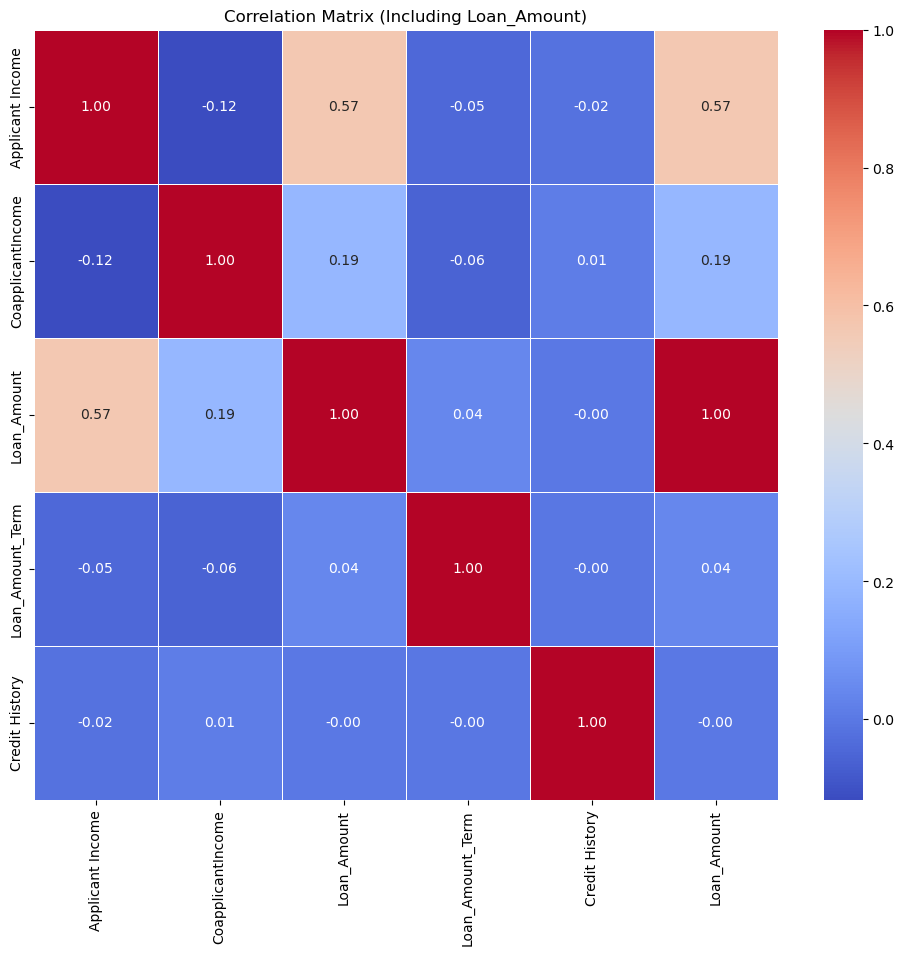

In [25]:
# Calculating the Correlation
# Reselecting numeric variable
numeric_data = df.select_dtypes(include=['int64', 'float64'])

# Correlation Analysis for X is the DataFrame
correlation_matrix = numeric_data.corr()

# Calculate correlation coefficients between all predictor variables and the target variable, Present_Tmax
correlation_with_ap = numeric_data.corrwith(numeric_dataR['Loan_Amount'])

# Concatenate the correlation coefficients with the original correlation matrix
correlation_matrix_with_ap = pd.concat([correlation_matrix, correlation_with_ap], axis=1)
correlation_matrix_with_ap.columns = list(correlation_matrix.columns) + ['Loan_Amount']

# Plot the correlation matrix including the target variable
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_with_ap, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Including Loan_Amount)")
plt.show()

Text 4:
A moderate positive correlation of 0.57 between applicant income and loan amount indicates that higher incomes are generally associated with larger 
loan amounts. While this suggests a trend, the correlation is not perfect, meaning other factors also influence loan amounts. Further analysis, such 
as regression will be considered in future, as it can provide deeper insights and account for additional variables.

Rows with outliers:
      Loan_ID  Gender Married Dependents     Education Self_Employed  \
4    LP001011    Male     Yes          2      Graduate           Yes   
6    LP001014    Male     Yes         3+      Graduate            No   
8    LP001020    Male     Yes          1      Graduate            No   
11   LP001028    Male     Yes          2      Graduate            No   
13   LP001030    Male     Yes          2      Graduate            No   
..        ...     ...     ...        ...           ...           ...   
599  LP002949  Female      No         3+      Graduate            No   
603  LP002959  Female     Yes          1      Graduate            No   
604  LP002960    Male     Yes          0  Not Graduate            No   
609  LP002979    Male     Yes         3+      Graduate            No   
612  LP002990  Female      No          0      Graduate           Yes   

     Applicant Income  CoapplicantIncome  Loan_Amount  Loan_Amount_Term  \
4                5417             4196.0

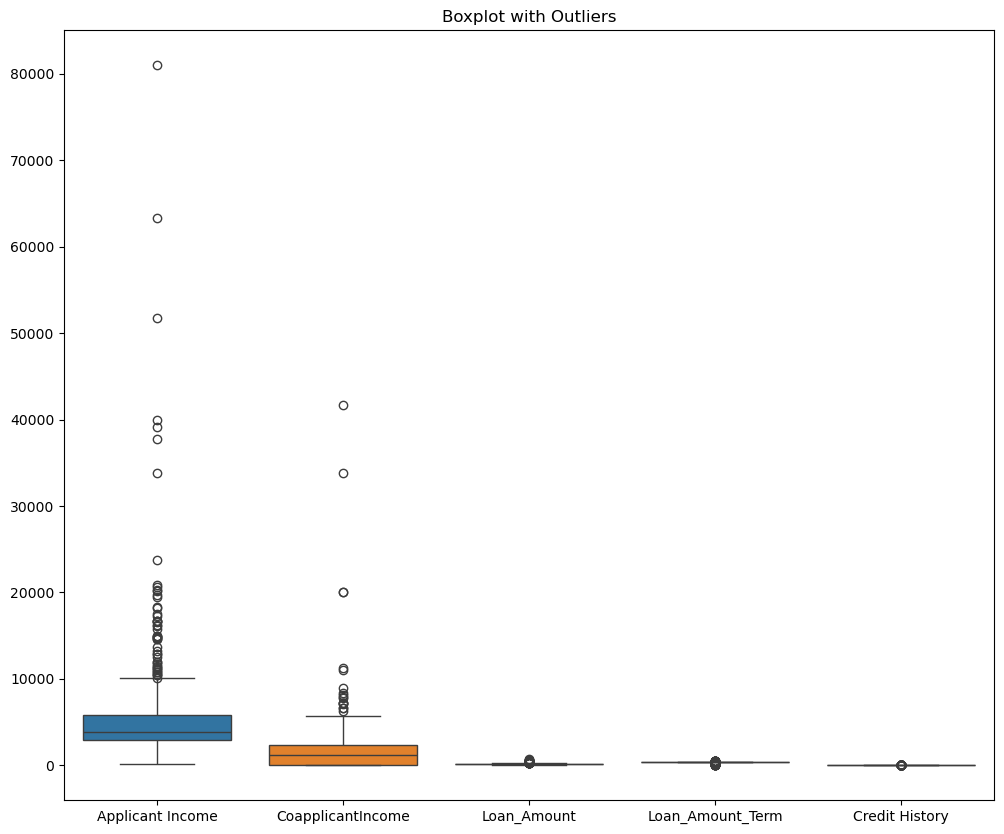

In [26]:
# Identifying Outliers
q1 = numeric_data.quantile(0.25)
q3 = numeric_data.quantile(0.75)
iqr = q3 - q1

# Define outlier conditions using IQR method
outlier_conditions = ((numeric_data < (q1 - 1.5 * iqr)) | (numeric_data > (q3 + 1.5 * iqr)))

# Display rows containing outliers
outliers = df[outlier_conditions.any(axis=1)]
print("Rows with outliers:")
print(outliers)

# Visualize the outliers using a boxplot
plt.figure(figsize=(12, 10))  
sns.boxplot(data=numeric_data)  # Assuming numeric_dataR contains the columns for visualization
plt.title("Boxplot with Outliers")
plt.show()


Text 5: 
The data suggest the presence of outlier values, particularly in Applicant Income, Coapplicant Income, Loan Amount, and Loan Amount Term columns, 
where extreme values deviate significantly from the typical range of observations. These outliers may warrant further investigation to determine their
impact on analysis and modelling outcomes.

Handling outliers in this case involves removing extreme data points by imputing median based on predefined criteria, variable will be transformed
using techniques like log transformation to mitigate impact on data analysis and modeling. The rationale ensures transparency and reproducibility 
in outlier treatment.

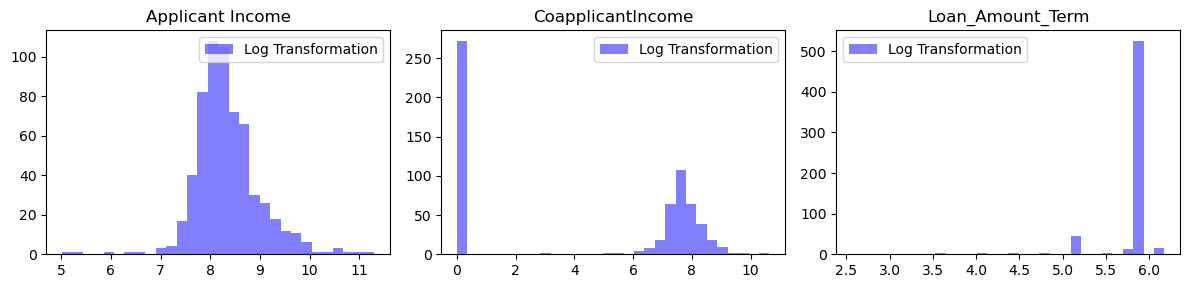

In [27]:
# Handling outliers
# Step 1: Identify Variables with Outliers
outlier_vars = ['Applicant Income', 'CoapplicantIncome', 'Loan_Amount_Term']

# Step 2: Apply Logarithmic Transformation
# Logarithmic Transformation
log_transformed_vars = df[outlier_vars].apply(lambda x: np.log(x + 1))  # Adding 1 to avoid log(0) issues

# Replace the original columns with the transformed columns
df[outlier_vars] = log_transformed_vars  

# Visualize the transformed data
plt.figure(figsize=(12, 8))
for i, col in enumerate(outlier_vars):
    plt.subplot(3, 3, i+1)
    plt.hist(log_transformed_vars[col], bins=30, alpha=0.5, color='blue', label='Log Transformation')
    plt.legend()
    plt.title(col)
plt.tight_layout()
plt.show()


Mean Squared Error: 3389.15
R^2 Score: 0.43


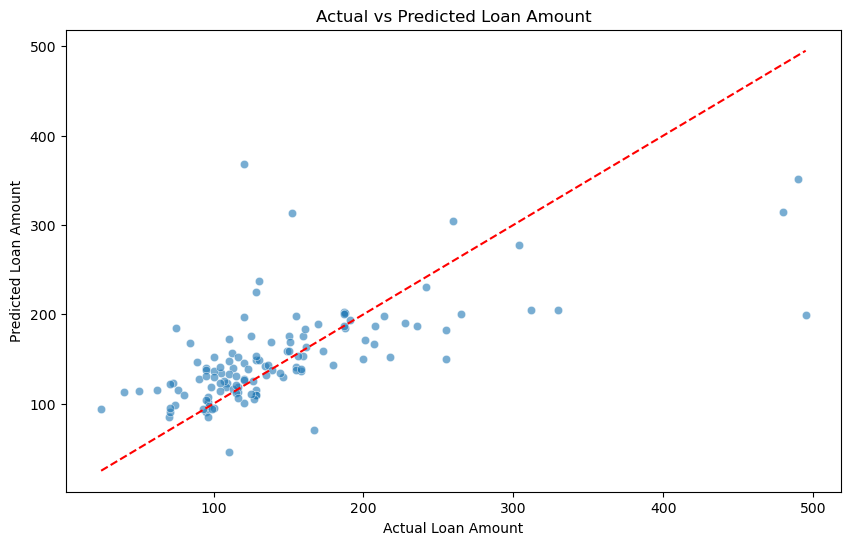

In [28]:
# Prepare the data
Xr = df[['Applicant Income', 'CoapplicantIncome', 'Loan_Amount_Term', 'Credit History']]
yr = df['Loan_Amount']

# Split the data into training and testing sets
X_trainr, X_testr, y_trainr, y_testr = train_test_split(Xr, yr, test_size=0.2, random_state=42)

# Create and fit the model
model = LinearRegression()
model.fit(X_trainr, y_trainr)

# Make predictions
y_pred = model.predict(X_testr)

# Evaluate the model
mse = mean_squared_error(y_testr, y_pred)
r2 = r2_score(y_testr, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Plot the predicted vs. actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_testr, y=y_pred, alpha=0.6)
plt.plot([y_testr.min(), y_testr.max()], [y_testr.min(), y_testr.max()], color='red', linestyle='--')
plt.xlabel('Actual Loan Amount')
plt.ylabel('Predicted Loan Amount')
plt.title('Actual vs Predicted Loan Amount')
plt.show()

In [30]:

# Feature Importance
coefficients = model.coef_
features = Xr.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print(importance_df)

             Feature  Coefficient
0   Applicant Income    86.997384
2   Loan_Amount_Term    10.923572
1  CoapplicantIncome     6.015965
3     Credit History     2.740116


Text 6:
Applicant Income (86.9): The most significant predictor; for each unit increase in income, the loan amount increases by approximately 86.9 units.
Coapplicant Income (6.01): Has a smaller positive impact; each unit increase in coapplicant income raises the loan amount. 
Credit History (2.81): Positively influences loan amount, with each unit increase in credit history increasing the loan by 2.64 units.
Loan Amount Term (10.63): The smallest impact; each additional unit in the term increases the loan amount by just 0.06 units.

Applicant Income has the most significant impact on the loan amount. Co-applicant Income and Credit History have positive but smaller effects.
Loan Amount Term has the least impact on the loan amount.

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Variable"] = numeric_data.columns

# Calculate VIF for each predictor variable
vif_data["VIF"] = [variance_inflation_factor(numeric_data.values, i) for i in range(len(numeric_data.columns))]

# Print the VIF DataFrame
print(vif_data)

            Variable       VIF
0   Applicant Income  2.844255
1  CoapplicantIncome  1.462888
2        Loan_Amount  6.480504
3   Loan_Amount_Term  7.729434
4     Credit History  5.803618


Text 7: 
Since all the variables have Variance Inflation Factor (VIF) values less than 10, indicating low multicollinearity, I will proceed to use all the data
without the concern of multicollinearity issues.

The selection of these variables is based on their Variance Inflation Factor (VIF) values, all below 10, indicating low multicollinearity and justifying their inclusion in the analysis. Outliers have been observed in variables like Applicant Income, Coapplicant Income, Loan Amount, and Loan Amount Term, where extreme values deviate significantly from the typical range. These necessitate the use of log transformation to ensure transparency and reproducibility in handling outliers.

In [32]:
# Set the random seed for reproducibility
np.random.seed(123)

# Split the dataset into features (X) and the target variable (y)
X = df[['Applicant Income', 'CoapplicantIncome', 'Loan_Amount', 'Loan_Amount_Term', 'Credit History', ]]  # Features (excluding categorical columns)
X_categorical = pd.get_dummies(df[['Married','Gender','Dependents','Education','Property_Area','Self_Employed']])  # One-hot encode categorical columns
X = pd.concat([X, X_categorical], axis=1)  # Combine numerical and encoded categorical features
y = df['Loan_Status']  # Target variable

# Standardize features and encode target variable
scaler = StandardScaler()
label_encoder = LabelEncoder()

X_scaled = scaler.fit_transform(X)  # Fit and transform the scaled features
y_encoded = label_encoder.fit_transform(y)  # Encode the target variable

# Split the dataset into training (80%) and testing (20%) sets using encoded labels
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=123)

In [33]:
# Checking for imbalance in the datasets.)
y.value_counts()

Loan_Status
Y    421
N    192
Name: count, dtype: int64

In [37]:
# Initialize SMOTE ( to address the class imbalance in the datasets.)
sm = SMOTE()

# The implementation of the fit_resample 
X,y = sm.fit_resample(X,y)

# Create a DataFrame to see the distribution of classes in the target vector y
data = pd.concat([X, y], axis=1)
class_distribution = data[y.name].value_counts()

print(class_distribution)

Loan_Status
N    421
Y    421
Name: count, dtype: int64


In [38]:
# Set the random seed
np.random.seed(123)

# Initialize classifiers
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()
logistic_regression = LogisticRegression()
support_vector_machine = SVC()

# Create a list of classifiers
classifiers = [random_forest, gradient_boosting, logistic_regression, support_vector_machine]

# Define the number of folds for cross-validation
num_folds = 5

# Perform k-fold cross-validation for each classifier
for clf in classifiers:
    print(f"Classifier: {clf.__class__.__name__}")
    
    # Initialize lists to store evaluation metrics for each fold
    accuracies = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    # Perform k-fold cross-validation
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=123)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the classifier
        clf.fit(X_train, y_train)
        
        # Making predictions on the test set
        y_pred = clf.predict(X_test)
        
        # Evaluate the classifier
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        # Append accuracy and classification report metrics to lists
        accuracies.append(accuracy)
        precision_scores.append(report['weighted avg']['precision'])
        recall_scores.append(report['weighted avg']['recall'])
        f1_scores.append(report['weighted avg']['f1-score'])
    
    # Compute average evaluation metrics over all folds
    avg_accuracy = np.mean(accuracies)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    
    # Print the results
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1-score: {avg_f1:.4f}")
    print("="*50)

Classifier: RandomForestClassifier
Average Accuracy: 0.8432
Average Precision: 0.8477
Average Recall: 0.8432
Average F1-score: 0.8429
Classifier: GradientBoostingClassifier
Average Accuracy: 0.8361
Average Precision: 0.8472
Average Recall: 0.8361
Average F1-score: 0.8351
Classifier: LogisticRegression
Average Accuracy: 0.8503
Average Precision: 0.8708
Average Recall: 0.8503
Average F1-score: 0.8483
Classifier: SVC
Average Accuracy: 0.5011
Average Precision: 0.6023
Average Recall: 0.5011
Average F1-score: 0.4065


In [39]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# Set the random seed
np.random.seed(123)

# Initialize LogisticRegression
logistic_regression = LogisticRegression(random_state=123)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'solver': ['liblinear']  # Algorithm to use in the optimization problem
}

# Initialize StratifiedKFold for cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=logistic_regression, param_distributions=param_grid, 
                                   cv=kfold, scoring='accuracy', n_iter=50)  # Adjust n_iter as needed

# Train the classifier with randomized search
random_search.fit(X_train, y_train)

# Get the best estimator from randomized search
best_classifier = random_search.best_estimator_

# Make predictions on the test set using the best classifier
y_pred = best_classifier.predict(X_test)

# Evaluate the best classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print(f"Best Classifier: {best_classifier.__class__.__name__}")
print(f"Best Parameters: {random_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)


Best Classifier: LogisticRegression
Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 10}
Accuracy: 0.8333
Classification Report:
               precision    recall  f1-score   support

           N       0.97      0.69      0.81        84
           Y       0.76      0.98      0.85        84

    accuracy                           0.83       168
   macro avg       0.86      0.83      0.83       168
weighted avg       0.86      0.83      0.83       168



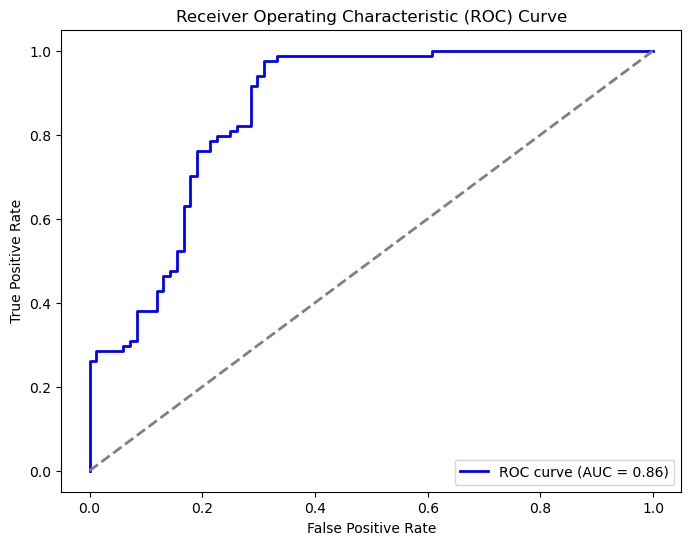

In [40]:
from sklearn.preprocessing import LabelBinarizer

# Convert categorical labels to binary format
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test)

# Compute the predicted probabilities for the positive class
y_pred_proba = best_classifier.predict_proba(X_test)[:, 1]

# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_proba)

# Compute the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve with AUC score
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [41]:
from joblib import dump
# Save the best LogisticRegression model to a file
dump(best_classifier, 'best_LogisticRegression_LoanApp.joblib')

['best_LogisticRegression_LoanApp.joblib']

Based on the findings of the analysis, it can be concluded that effective preprocessing steps, including outlier handling and addressing 
multicollinearity through techniques like logarithmic transformation and variance inflation factor (VIF) analysis, are crucial for enhancing 
the performance of predictive models. 

In terms of model selection, LogisticRegression emerged as the most effective classifier among RandomForestClassifier, GradientBoostingClassifier, 
and itself, showcasing superior performance metrics such as accuracy, precision, recall, and F1-score. This result underscores the significance of 
choosing appropriate algorithms tailored to the dataset characteristics and problem domain.

Moreover, hyperparameter tuning, as exemplified by the {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'} configuration in LogisticRegression with
Accuracy: 83%.